# Skyline Hospital Time Series Forecasting with XGBoost

## 1. Import required libraries and modules

In [1]:
# Data manipulation libraries
import pandas as pd
import pyarrow
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))

import warnings
warnings.filterwarnings('ignore')

# ML algorithm for time series forecasting
import xgboost as xgb

# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error  

<Figure size 1200x600 with 0 Axes>

## 2. Load and read the data

In [2]:
filepath = 'data/skyline_hospital_bill_charge_report.csv'
df = pd.read_csv(filepath)

# Print the first 5 rows of the data
df.head()

,Open Date,Bill No.,Charge Head,Doctor Code,Qty
0,2020-05-18,BL427653,OP Consultation,DOC0114,1
1,2020-05-18,BL427654,OP Consultation,DOC0114,1
2,2020-05-18,BL427655,OP Consultation,DOC0207,1
3,2020-05-18,BL427656,OP Consultation,DOC0114,1
4,2020-05-18,BL427657,OP Consultation,DOC0114,1


In [3]:
df.tail()

,Open Date,Bill No.,Charge Head,Doctor Code,Qty
126152,2022-12-31,BL678528,OP Consultation,DOC0553,1
126153,2022-12-31,BL678529,OP Consultation,DOC0207,1
126154,2022-12-31,BL678530,OP Consultation,DOC0114,1
126155,2022-12-31,BL678531,OP Consultation,DOC0114,1
126156,2022-12-31,BL678535,OP Consultation,DOC0207,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126157 entries, 0 to 126156
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Open Date    126157 non-null  object
 1   Bill No.     126157 non-null  object
 2   Charge Head  126157 non-null  object
 3   Doctor Code  126157 non-null  object
 4   Qty          126157 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.8+ MB


The dataset is a bill charge report from Skyline Hospital and Medical Center's outpatient unit. It lists down **outpatient consultations from 2020-05-18 to 2022-12-31**, providing us with **2 years, 7 months, and 14 days** worth of outpatient consultations.

It can be seen that the number of observations is large. There are 126,157 observations (rows) and 5 variables (columns). The column names include: `'Bill No.'`, `'Open Date'`, `'Charge Head'`, `'Doctor Code'`, and `'Qty`. For time series forecasting, only the dates (`Open Date`) and the count of outpatient consultations (`Qty`) shall be used. Therefore, the 3 remaining columns are to be dropped, which will make this a time series data.

## 3. Data Cleaning

In [5]:
# Subset the data to only include `'Open Date'` and `'Qty'`
df = df[['Open Date', 'Qty']]
df.columns

Index(['Open Date', 'Qty'], dtype='object')

To make the columns more understandable, we can rename `'Open Date'` as `'Date'` and `'Qty'` as `'Patients'`, representing the number of patients for each date.

In [6]:
df = df.rename(columns={'Open Date': 'Date', 'Qty': 'Patients'})
df.columns

Index(['Date', 'Patients'], dtype='object')

In [7]:
df.dtypes

Date        object
Patients     int64
dtype: object

We can see that the `'Date'` column is read with an `object` data type. We must change this to the pandas `datetime` format using `to_datetime()`. This will allow us to truly perceive it as time data, and use appropriate `datetime` functions for it.

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date        datetime64[ns]
Patients             int64
dtype: object

We can leave the `Patients` column's data type as is, an integer data type. Now let's have another look on our data.

In [9]:
df['Date'].value_counts()

Date
2022-11-26    315
2022-10-01    306
2022-11-05    297
2022-06-11    293
2022-08-06    283
             ... 
2021-05-23      1
2021-05-02      1
2021-04-25      1
2021-04-04      1
2022-07-10      1
Name: count, Length: 856, dtype: int64

In [10]:
df['Date']

0        2020-05-18
1        2020-05-18
2        2020-05-18
3        2020-05-18
4        2020-05-18
            ...    
126152   2022-12-31
126153   2022-12-31
126154   2022-12-31
126155   2022-12-31
126156   2022-12-31
Name: Date, Length: 126157, dtype: datetime64[ns]

Having a closer look at our time series data lets us know that we have duplicated dates, and the **patient arrival counts are not summed up in one date** or instance. This is why we have more observations (rows) than what is expected. An easy fix for this would be to use `groupby()` on the `'Date'` column with the `sum()` method on the `'Patients'` column.

In [11]:
df = df.groupby(by='Date', as_index=False)['Patients'].sum()
df['Date'].value_counts()

Date
2020-05-18    1
2022-02-05    1
2022-02-08    1
2022-02-09    1
2022-02-10    1
             ..
2021-04-07    1
2021-04-08    1
2021-04-09    1
2021-04-10    1
2022-12-31    1
Name: count, Length: 856, dtype: int64

In [12]:
df[df['Date'].duplicated()]

,Date,Patients


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


Since this seems to be cleaned enough data, we can save the time series data that was once a csv file, into a **parquet file**. This would allow us to **reduce memory consumption**.                                  

In [14]:
df.to_parquet('data/patient_arrivals.parquet')

Let's load and read the data once again.

In [15]:
parquet_file = 'data/patient_arrivals.parquet'
df = pd.read_parquet(parquet_file, engine='pyarrow')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


A convention with time series data is to set the `datetime` column into an index.

In [17]:
df = df.set_index('Date')
df

,Patients
Date,
2020-05-18,67
2020-05-19,75
2020-05-20,74
2020-05-21,55
2020-05-22,62
...,...
2022-12-27,114
2022-12-28,156
2022-12-29,105


Now we can see that the duplicated dates issue on the data is fixed, and has significantly **reduced the number of observations from 126,157 to just 856**. But this poses another issue, if we convert 2 years, 7 months, and 14 days into just the number of days, **we should be getting 958 days/rows**. Let's **define the date range for this so that we can have the true number of days from 2020-05-18 to 2022-12-31**.

In [28]:
new_index = pd.date_range(start='2020-05-18', end='2022-12-31', freq='D')
df = df.reindex(new_index, fill_value=0)
df.index.name = 'Date'
df

,Patients
Date,
2020-05-18,67.0
2020-05-19,75.0
2020-05-20,74.0
2020-05-21,55.0
2020-05-22,62.0
...,...
2022-12-27,114.0
2022-12-28,156.0
2022-12-29,105.0


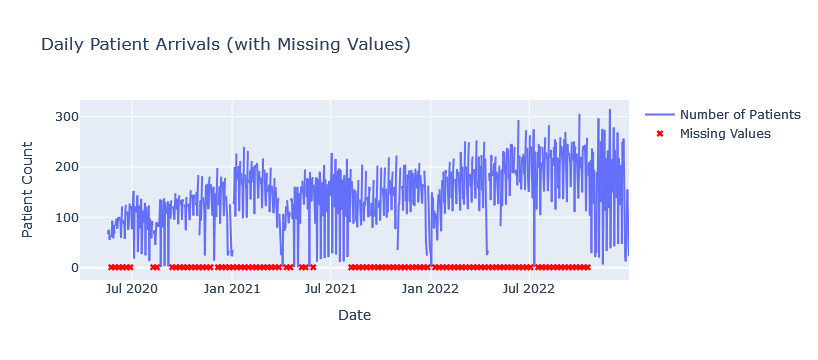

In [33]:
fig = go.Figure()

# Add scatter trace for patients
fig.add_trace(go.Scatter(x=df.index, y=df['Patients'], 
                          mode='lines', 
                          name='Number of Patients'))

# Add markers for missing values
missing_dates = df[df['Patients'].isna()].index
missing_values_trace = go.Scatter(x=missing_dates, y=[df['Patients'].min()]*len(missing_dates),
                                  mode='markers', marker=dict(color='red', symbol='x'),
                                  name='Missing Values')
fig.add_trace(missing_values_trace)

# Set plot title and axis labels
fig.update_layout(title='Daily Patient Arrivals (with Missing Values)',
                  xaxis_title='Date', yaxis_title='Patient Count')

# Show plot
fig.show()

In [35]:
missing_vals = df[df['Patients'].isna()]
missing_vals

,Patients
Date,
2020-05-24,NaN
2020-05-31,NaN
2020-06-07,NaN
2020-06-14,NaN
2020-06-21,NaN
...,...
2022-09-18,NaN
2022-09-25,NaN
2022-10-02,NaN


We can see **102 missing instances** of patient arrival counts. To see the pattern of missing values, we can add a time series feature to identify which days of the week are the missing values coming from.

In [37]:
df = df.copy()
df['date'] = df.index
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

,Patients,date,day_of_week
Date,,,
2020-05-18,67.0,2020-05-18,0
2020-05-19,75.0,2020-05-19,1
2020-05-20,74.0,2020-05-20,2
2020-05-21,55.0,2020-05-21,3
2020-05-22,62.0,2020-05-22,4


The week numbers in the `'day_of_week'` here could be perceived as:

- `0` : `Monday`
- `1` : `Tuesday`
- `2` : `Wednesday`
- `3` : `Thursday`
- `4` : `Friday`
- `5` : `Saturday`
- `6` : `Sunday`


<Axes: xlabel='day_of_week'>

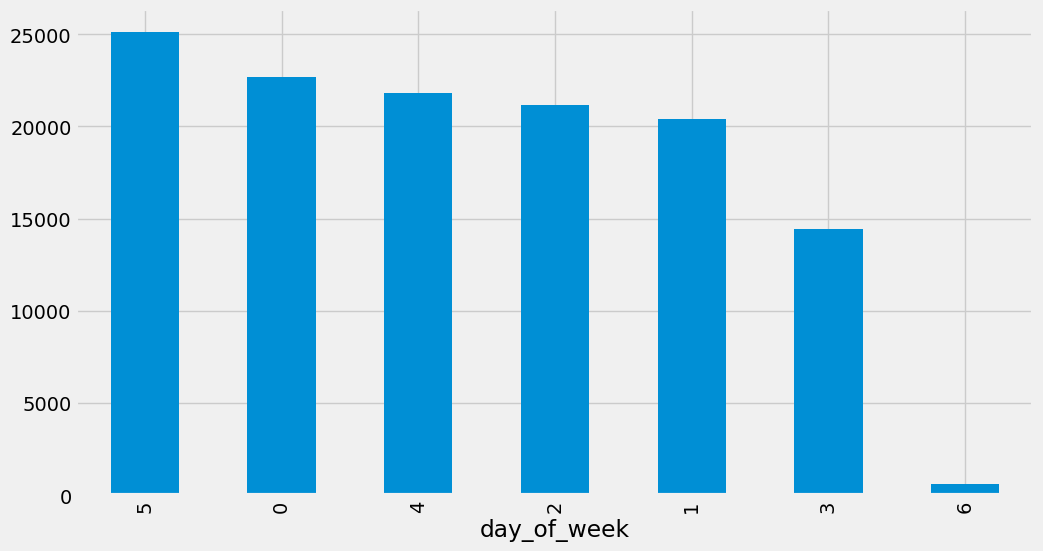

In [52]:
df.groupby('day_of_week')['Patients'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))

**Saturday** seems to be the day of the week with the **highest patient arrival counts**. Consequently, **Sunday** seems to be the one with the **lowest patient arrival counts**. What could this possibly mean?